## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade bigdl-chronos[all]`. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-chronos[all]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 289 kB 36.5 MB/s 
     |████████████████████████████████| 23.9 MB 1.2 MB/s 
     |████████████████████████████████| 2.3 MB 2.1 MB/s 
     |████████████████████████████████| 9.9 MB 56.6 MB/s 
     |████████████████████████████████| 5.2 MB 50.2 MB/s 
     |████████████████████████████████| 13.1 MB 50.6 MB/s 
     |████████████████████████████████| 71.0 MB 385 bytes/s 
     |████████████████████████████████| 51.6 MB 1.3 MB/s 
     |████████████████████████████████| 35.4 MB 153 kB/s 
     |████████████████████████████████| 218.4 MB 59 kB/s 
     |████████████████████████████████| 51.0 MB 65 kB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 58.2 MB/s 
     |███████████████████████████

Found existing installation: torchtext 0.13.0
Uninstalling torchtext-0.13.0:
  Successfully uninstalled torchtext-0.13.0


## **Step 0: Prepare dataset**

In [2]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Big Data/Final Project/Training_Traffic_Count_M50_Between_Jn02_Santry_and_Jn03 -2 columns.csv", parse_dates=["timestamp"])

### **Step 1: Init Orca Context** 

In [2]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [3]:
# recommended to set it to True when running bigdl-chronos in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2022-07-16 06:45:04,435	INFO services.py:1340 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-07-16_06-45-00_779726_417/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-16_06-45-00_779726_417/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-07-16_06-45-00_779726_417', 'metrics_export_port': 53259, 'node_id': '411acc799024b2ad53e142313949860c3dafcf7fbc7d9075b4f2d3d9'}


<SparkContext master=local[4] appName=pyspark-shell>

### **Step 2: Data transformation and feature engineering using Chronos TSDataset**
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [4]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, # the dataframe to load
                                                              dt_col="timestamp",  # the column name specifying datetime
                                                              target_col="value", # the column name to predict
                                                              with_split=True, # split the dataset into 3 parts
                                                              val_ratio=0.1, # validation set ratio
                                                              test_ratio=0.1) # test set ratio

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Step 3: Create an AutoTSEstimator**


[AutoTSEstimator](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [5]:
# import bigdl.orca.automl.hp as hp
# from bigdl.chronos.autots import AutoTSEstimator
# auto_estimator = AutoTSEstimator(model='lstm', # the model name used for training
#                                  search_space='normal', # a default hyper parameter search space
#                                  past_seq_len=hp.randint(1, 10)) # hp sampling function of past_seq_len for auto-tuning

import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='lstm', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=10) # hp sampling function of past_seq_len for auto-tuning

### **Step 4: Fit with AutoTSEstimator**

In [ ]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=100) # number of epochs to train in each trial

### **Step 5: Further deployment with TSPipeline**

[TSPipeline](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline-experimental) is our E2E solution for time series forecasting task.

In [7]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

In [8]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 94263.12390874364
Evaluate: the smape value is 3.8576094058773007


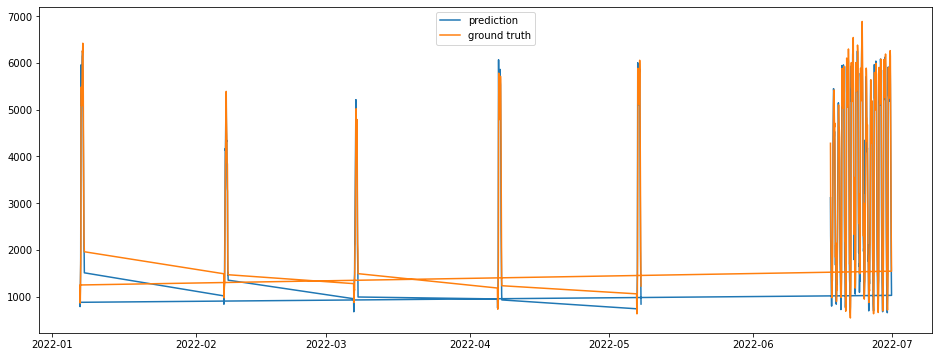

In [9]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(16,6))
plt.plot(groundtruth_unscale["timestamp"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["timestamp"], groundtruth_unscale["value"])
plt.legend(["prediction", "ground truth"])

In [10]:
# save the pipeline
my_ppl_file_path = "/tmp/saved_pipeline"
ts_pipeline.save(my_ppl_file_path)

In [11]:
# restore the pipeline for further deployment
from bigdl.chronos.autots import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07077080656218555 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Test Model With Brandnew Dataset


In [12]:
df_valid = pd.read_csv('/content/drive/MyDrive/Big Data/Final Project/Traffict_count_tets_set.csv', parse_dates=["timestamp"])

In [ ]:
df_valid = df_valid.drop(['Date', 'Time'], axis=1)
pd.to_datetime(df_valid['timestamp'])

In [14]:
valid_set = TSDataset.from_pandas(df_valid, # the dataframe to load
                                  dt_col="timestamp",  # the column name specifying datetime
                                  target_col="value", # the column name to predict
                                  with_split=False, # split the dataset into 3 parts
                                  val_ratio=0.1, # validation set ratio
                                  test_ratio=0.1) # test set ratio
# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
valid_set.gen_dt_feature()\
      .impute(mode="last")\
      .scale(standard_scaler, fit=True)

In [ ]:
valid_set.to_pandas()


In [15]:
valid_value = ts_pipeline.predict(valid_set)

In [ ]:
valid_value

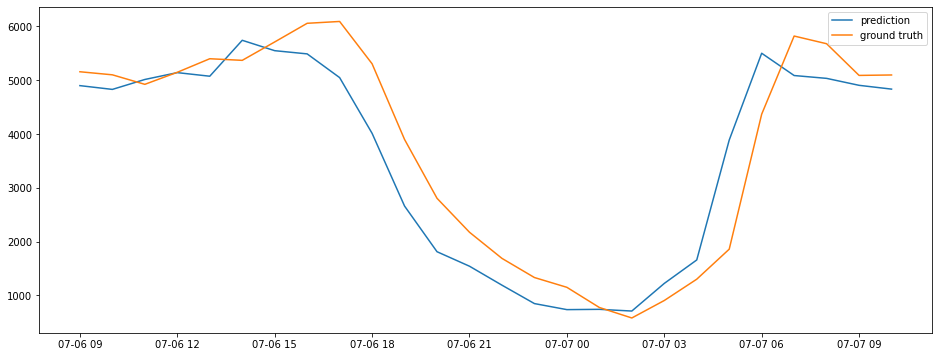

In [16]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = valid_set.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(16,6))
plt.plot(groundtruth_unscale["timestamp"], valid_value[:,0,0])
plt.plot(groundtruth_unscale["timestamp"], groundtruth_unscale["value"])
plt.legend(["prediction", "ground truth"])

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()